In [16]:
%matplotlib inline

In [97]:
import os
import sys
import json
sys.path.append('..')
import time

import pylab
import numpy as np
from pprint import pprint
from IPython.display import Image
from matplotlib.dates import date2num, num2date
from datetime import datetime, timedelta
from pysurvey.plot import setup, icolorbar, dateticks, minmax

In [ ]:
json.dump()

In [4]:
import numerousobject.api
reload(numerousobject.api)

<module 'numerousobject.api' from '../numerousobject/api.pyc'>

In [5]:
username, password = numerousobject.api.credentials()

In [94]:
api = numerousobject.api.API(username, password)
api.login()
device = api.deviceinfo(1)
alerts = api.alert(device)
clips = api.listclips(device)
print datetime.fromtimestamp(api.logininfo['time']/1000)
print datetime.now()

Logged in as blue.space@gmail.com [370897]
2015-12-28 11:23:43
2015-12-28 11:23:44.720556


In [83]:
# Figure out start time from boost exp
tmp = datetime.fromtimestamp(api.logininfo['accountInfo']['boost']['expires']/1000)
tmp - timedelta(days=30)

datetime.datetime(2015, 12, 19, 19, 0)

In [84]:
# This is how we do the time shuffle... err ok
a = int(round(api.logininfo['time']/1000.0))
tmp = datetime.fromtimestamp(api.logininfo['time']/1000)
b = time.mktime(tmp.timetuple())
tmp2 = datetime.fromtimestamp(int(b))
print a, b, a-b
print api.logininfo['time'], tmp, tmp2

1451319288 1451319287.0 1.0
1451319287588 2015-12-28 11:14:47 2015-12-28 11:14:47


In [85]:
# pprint(api.livesession(device))
alerts = api.alert(device)
alert = alerts[0]
# pprint(alert)
print api.video(device, session=alert['alert'],
                starttime=alert['startt']/1000, 
                endtime=alert['endt']/1000)
motion = api.get(device, alert['startt']/1000)
print motion.keys()

[]
[u'msg', u'result']


In [86]:
print datetime.fromtimestamp(motion['msg'][0])
print datetime.fromtimestamp(motion['msg'][1])

2015-12-27 19:00:00
2015-12-28 19:00:00


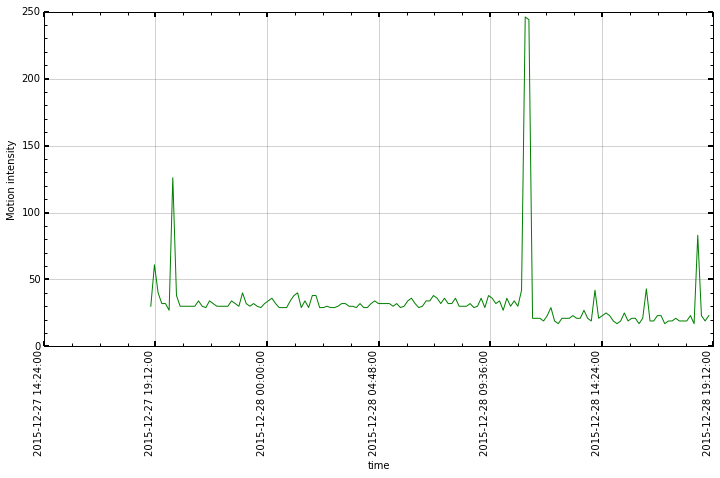

In [17]:
def plot_motion(motion):
    audio = motion['result']['audio']
    video = motion['result']['video']
    
    start,end = date2num(map(datetime.fromtimestamp, motion['msg']))
    times = np.linspace(start, end, len(audio))
    
    setup(figsize=(12,6),  xlabel='time', ylabel='Motion intensity')
    pylab.plot(times, audio, label='audio')
    pylab.plot(times, video, label='video')
    dateticks('%Y-%m-%d %H:%M:%S', rotation=90)
    
plot_motion(motion)

In [87]:
def getalerts(self, device):
    done = False
    out = []
    offset = 0
    while not done:
        print len(out), 
        try:
            alerts = self.alert(device, offset=offset)
            if len(alerts) == 0:
                done = True
            out.extend(alerts)
            offset += 20
        except Exception as e:
            print e
            break
    for alert in out:
        alert['datestr'] = str(datetime.fromtimestamp(alert['alert']))
    return out


allalerts = getalerts(api, device)

0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 482


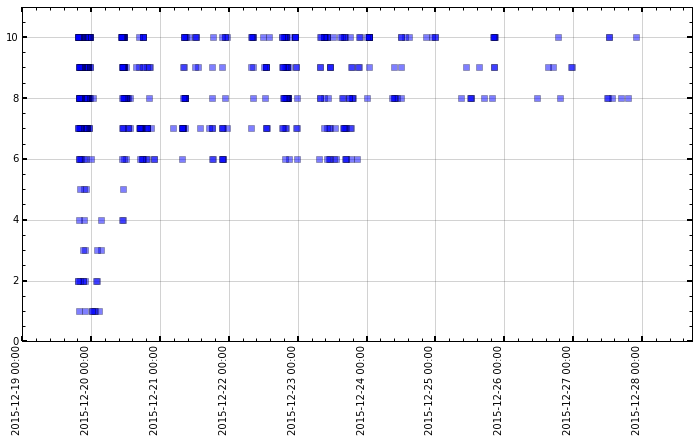

In [88]:
smx = [int(str(alert['smx']), 16) for alert in allalerts]
tmp = [datetime.fromtimestamp(alert['alert']) for alert in allalerts]
setup(figsize=(12,6), yr=[0,11], xr=minmax(tmp), embiggenx=0.1)
pylab.plot(tmp, smx, 's', alpha=0.5, lw=0)
dateticks('%Y-%m-%d %H:%M', rotation=90)

In [89]:
def getmotion(self, device):
    start = time.mktime(datetime(2015, 12, 19).timetuple())
    current = time.mktime(datetime.now().timetuple())
#     delta = timedelta(days=1).total_seconds()
    delta = timedelta(hours=12).total_seconds()
    done = False
    out = {}
    while not done:
        print '.',
        tmp = self.get(device, current)
#         print tmp
        tmp['current'] = current
        tmp['requested'] = str(datetime.now())
        out[current] = tmp
        current -= delta
        if current < start:
            break
#         if len(out) > 2:
#             break
    return out

motion = getmotion(api, device)

. . . . . . . . . . . . . . . . . . .


In [90]:
x,y,z = [],[],[]
for current,info in motion.iteritems():
    if 'err' in info:
        continue
    video = [(t if isinstance(t,int) else 0) 
             for t in info['result']['video']]
    start,end = date2num(map(datetime.fromtimestamp, info['msg']))
    x.extend(np.linspace(start, end, len(video)))
    y.extend(video)
    print len(x), len(video), info.keys()
x,y,z = map(np.array, (x,y,z))

864 864 [u'msg', 'current', u'result', 'requested']
1728 864 [u'msg', 'current', u'result', 'requested']
2499 771 [u'msg', 'current', u'result', 'requested']
3363 864 [u'msg', 'current', u'result', 'requested']
4134 771 [u'msg', 'current', u'result', 'requested']
4998 864 [u'msg', 'current', u'result', 'requested']
5862 864 [u'msg', 'current', u'result', 'requested']
6726 864 [u'msg', 'current', u'result', 'requested']
7590 864 [u'msg', 'current', u'result', 'requested']
8175 585 [u'msg', 'current', u'result', 'requested']
9039 864 [u'msg', 'current', u'result', 'requested']
9903 864 [u'msg', 'current', u'result', 'requested']
10767 864 [u'msg', 'current', u'result', 'requested']
11352 585 [u'msg', 'current', u'result', 'requested']
12216 864 [u'msg', 'current', u'result', 'requested']
13080 864 [u'msg', 'current', u'result', 'requested']


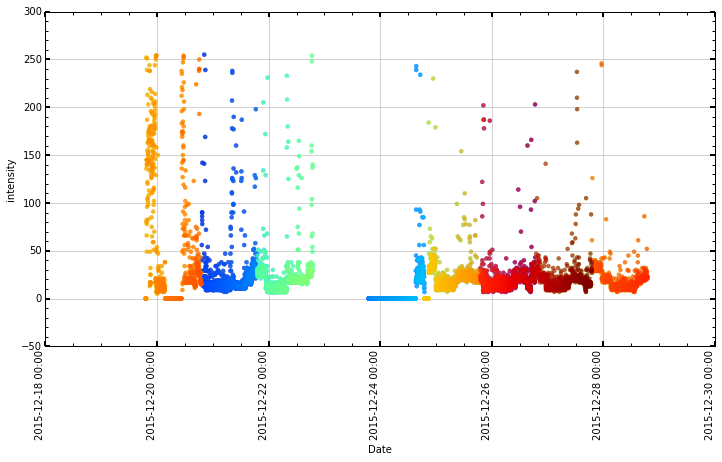

In [91]:
setup(figsize=(12,6), xlabel='Date', ylabel='intensity')
pylab.scatter(x,y, c=np.arange(len(x)), lw=0, alpha=0.6)
dateticks('%Y-%m-%d %H:%M', rotation=90)

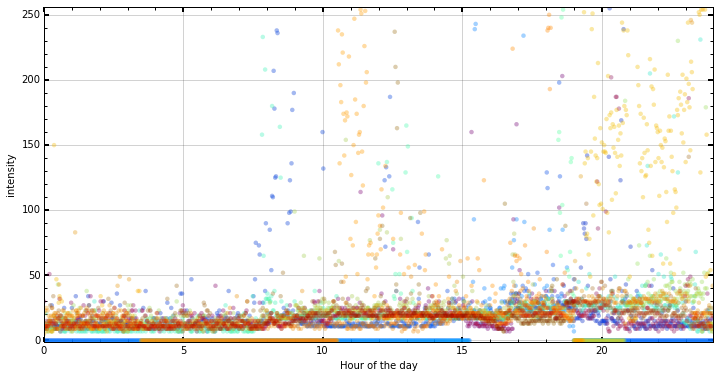

In [108]:
setup(figsize=(12,6), 
      xr=[0,24], xlabel='Hour of the day', 
      yr=[-1,256], ylabel='intensity')
pylab.scatter((x%1.0)*24, y, c=np.arange(len(x)), lw=0, alpha=0.2)
# dateticks('%Y-%m-%d %H:%M', rotation=90)

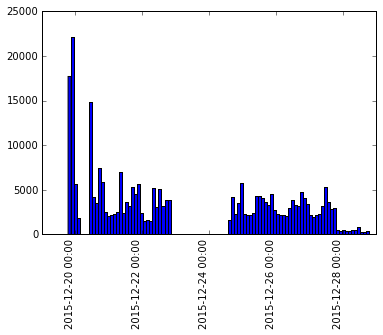

In [23]:
_ = pylab.hist(x, weights=y, bins=100)
dateticks('%Y-%m-%d %H:%M', rotation=90)

6879


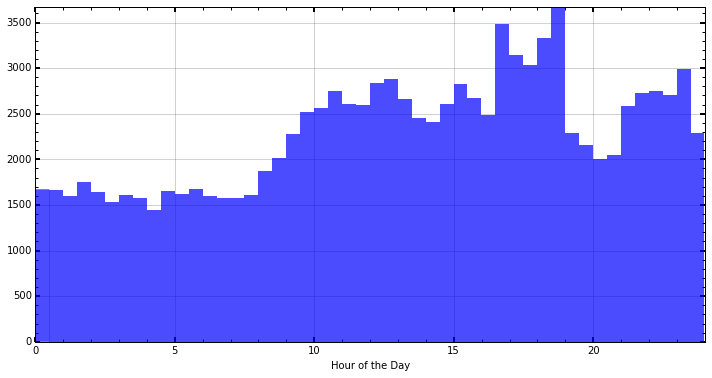

In [24]:

ii = np.where(x >= date2num(datetime(2015,12,23)))[0]
print len(ii)
setup(figsize=(12,6), xr=[0,24], xlabel='Hour of the Day')
_ = pylab.hist((np.array(x)[ii]%1.0)*24, weights=np.clip(y, 0,50)[ii], 
               bins=48, lw=0, alpha=0.7)

In [93]:
OUTDIR = '/Volumes/video/backup_manything/alerts'
# def saveimage(self, filename, image):
#     open(filename, 'w').write(image)


def getalertstills(self, device, alerts):
    for i, alert in enumerate(alerts):
        print i,
#         print 'working on: {}'.format(alert['alert'])
        
        outdir = os.path.join(OUTDIR, '{}'.format(alert['alert']))
        if not os.path.exists(outdir):
            os.makedirs(outdir)
            
        
        stills = self.liststills(device, alert['alert'],
                                 starttime=alert['startt']/1000,
                                 endtime=alert['endt']/1000)
        for still in stills:
            filename = os.path.join(outdir, '{}.jpg'.format(still))
            if os.path.exists(filename):
#                 print '.',
                continue
            img = api.getstill(device, still)
            saveimage(self, filename, img)
#         break
        
getalertstills(api, device, allalerts)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [95]:
sessions = api.session(device)

In [92]:
def saveimage(self, filename, image):
    try:
        with open(filename, 'w') as f:
            f.write(image)
    except Exception as e:
        os.remove(filename)
        raise
    

In [ ]:
OUTDIR = '/Volumes/video/backup_manything/sessions'

endtime = time.mktime(datetime.now().timetuple())
for session in sessions:
    
    outdir = os.path.join(OUTDIR, '{}'.format(session['session']))
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    
    infofile = os.path.join(outdir, 'list.npy')
    if os.path.exists(infofile):
        stills = np.load(infofile)
    else:
        stills = api.liststills(device, session['session'], 
                             starttime=session['startt']/1000,
                             endtime=endtime)
        np.save(infofile, stills)
    
    print 'Session {} [{}] has {:,d} stills'.format(session['session'], 
                                                    datetime.fromtimestamp(session['session']),
                                                    len(stills))
    endtime = np.min(stills)
    for j, still in enumerate(stills):
        nicetime = int(np.floor(still/1000.0)*1000.0)
        filename = os.path.join(outdir, 
                                '{0:d}_{1:%Y}.{1:%m}.{1:%d}_{1:%H}.{1:%M}'.format(nicetime, datetime.fromtimestamp(nicetime)),
                                '{}.jpg'.format(still))
        basedir = os.path.dirname(filename)
        if not os.path.exists(basedir):
            os.makedirs(basedir)
        if os.path.exists(filename):
            continue
        img = api.getstill(device, still)
        if 'invalid token' in img:
            print img
            raise ValueError('Issue!')
        saveimage(api, filename, img)
        if (j%1000) == 0:
            print j/1000,
#             break
#     print len(stils)
#     break

In [103]:
tmp = os.stat(filename)
tmp.st_mtime

1451323342.0

In [74]:
'{0:d}_{1:%Y}.{1:%m}.{1:%d}_{1:%H}.{1:%M}'.format(int(np.round(1451008217,-3)), datetime.fromtimestamp(1451008217))


'1451008000_2015.12.24_20.50'

In [60]:
datetime.fromtimestamp(1450923014),datetime.fromtimestamp(1451315986),

(datetime.datetime(2015, 12, 23, 21, 10, 14),
 datetime.datetime(2015, 12, 28, 10, 19, 46))

In [134]:
stills = api.liststills(device, alert['alert'], 
               alert['startt']/1000, alert['endt']/1000)

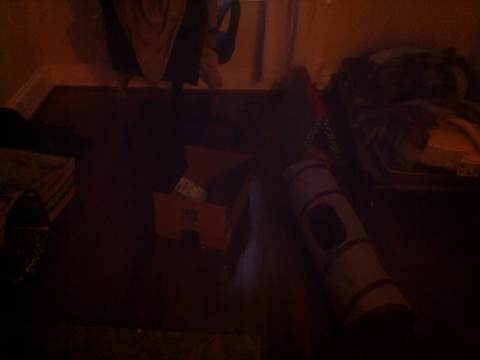

In [135]:
still = stills[0]
filename = '/Users/ajmendez/tmp/image.jpg'
open(filename, 'w').write(api.getstill(device, still))
Image(filename)

In [84]:

for alert in alerts:
    print api.liststills(device, session=alert['alert'],
                         starttime=alert['startt'],
                         endtime=alert['endt'], iscomplex=False)
    break

[]


In [126]:
for clip in clips:
#     print clip['startt'], clip['id'], clip['type'], clip['endt']-clip['startt'], clip['finished']-clip['created'], clip['description']
    print api.video(device, clip['startt'], clip['endt'])
    break

[]


In [58]:

# http://clips.manything.com/clips/xxx/clip.mp4
#     http://clips.manything.com/clips/xxx/clip.mp4

[]

In [72]:
import requests

In [101]:
# application/x-fcs
headers = {
    'Content-Type':'application/x-fcs',
    'Origin':'https://manything.com',
    'Referer':'https://manything.com/manything/',
    'User-Agent':'Shockwave Flash',
    'X-Requested-With':'ShockwaveFlash/20.0.0.228',
}
response = requests.post('https://{}/open/1'.format(device['wowza']), headers=headers)
a=response.content.strip()
# response = requests.post('https://{}.manything.com/idle/{}/0'.format(device['wowza'],a), headers=headers)
print a, response.content
# response = requests.post('https://useast1-wowza-xxx.manything.com/send/1116577027/1')
# print response.content

229446293 229446293

